  param  true    ls_est    gd_est
0   Q11   2.0  2.002643  1.976992
1   Q12   0.8  0.398493  0.812953
2   Q22   1.5  1.506039  1.516272
3    v1   0.5  0.501648  0.327330
4    v2  -1.2 -1.190821 -0.758087


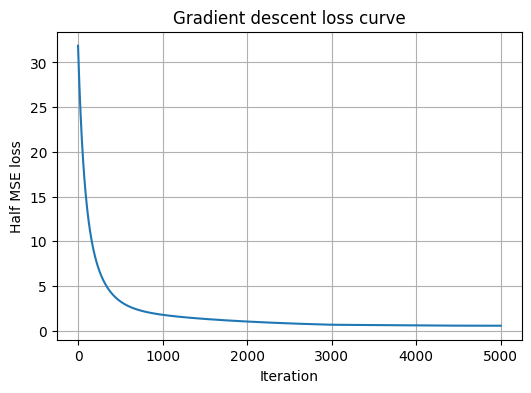

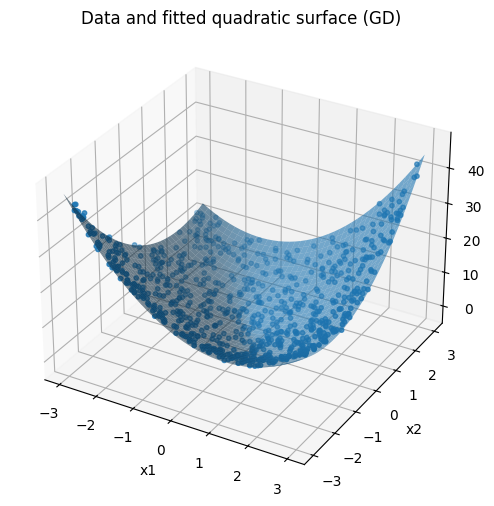

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)

# ======================
# 1. 生成真实参数
# ======================
Q_true = np.array([[2.0, 0.8],
                   [0.8, 1.5]])
v_true = np.array([0.5, -1.2])

def f_quad(x, Q, v):
    return np.einsum('...i,ij,...j->...', x, Q, x) + x @ v

# ======================
# 2. 生成带噪声数据
# ======================
N = 800
X = np.random.uniform(-3, 3, size=(N, 2))
noise_sigma = 0.7
y_clean = f_quad(X, Q_true, v_true)
y = y_clean + np.random.normal(scale=noise_sigma, size=N)

# ======================
# 3. 构造设计矩阵
# ======================
A = np.column_stack([
    X[:,0]**2,
    2*X[:,0]*X[:,1],
    X[:,1]**2,
    X[:,0],
    X[:,1]
])

# ======================
# 4. 最小二乘解 (闭式解)
# ======================
theta_ls, *_ = np.linalg.lstsq(A, y, rcond=None)
a_ls = theta_ls[0]
b_ls = theta_ls[1] / 2.0
c_ls = theta_ls[2]
v1_ls = theta_ls[3]
v2_ls = theta_ls[4]

# ======================
# 5. 梯度下降法拟合
# ======================
def predict_from_p(p, X):
    a, b, c, v1, v2 = p
    return a*X[:,0]**2 + 2*b*X[:,0]*X[:,1] + c*X[:,1]**2 + v1*X[:,0] + v2*X[:,1]

p = np.array([1.0, 0.0, 1.0, 0.0, 0.0])
lr = 0.0001
num_iters = 5000
loss_history = np.zeros(num_iters)

for it in range(num_iters):
    y_pred = predict_from_p(p, X)
    err = y_pred - y
    loss = (err**2).mean() / 2.0
    loss_history[it] = loss

    grad = (A.T @ err) / N
    grad_param = grad.copy()
    grad_param[1] = grad[1] * 2.0  # 因为设计矩阵第二列是 2*b
    p = p - lr * grad_param

    if it == int(num_iters*0.6):
        lr *= 0.3
    if it == int(num_iters*0.9):
        lr *= 0.2

# ======================
# 6. 结果对比
# ======================
a_gd, b_gd, c_gd, v1_gd, v2_gd = p
Q_est_gd = np.array([[a_gd, b_gd],[b_gd, c_gd]])
v_est_gd = np.array([v1_gd, v2_gd])

Q_est_ls = np.array([[a_ls, b_ls],[b_ls, c_ls]])
v_est_ls = np.array([v1_ls, v2_ls])

df = pd.DataFrame({
    'param': ['Q11','Q12','Q22','v1','v2'],
    'true': [Q_true[0,0], Q_true[0,1], Q_true[1,1], v_true[0], v_true[1]],
    'ls_est': [Q_est_ls[0,0], Q_est_ls[0,1], Q_est_ls[1,1], v_est_ls[0], v_est_ls[1]],
    'gd_est': [Q_est_gd[0,0], Q_est_gd[0,1], Q_est_gd[1,1], v_est_gd[0], v_est_gd[1]]
})
print(df)

# ======================
# 7. 可视化
# ======================
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Half MSE loss")
plt.title("Gradient descent loss curve")
plt.grid(True)
plt.show()

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], y, s=10)

xx = np.linspace(X[:,0].min(), X[:,0].max(), 40)
yy = np.linspace(X[:,1].min(), X[:,1].max(), 40)
XX, YY = np.meshgrid(xx, yy)
Pts = np.column_stack([XX.ravel(), YY.ravel()])
ZZ = predict_from_p(p, Pts).reshape(XX.shape)

ax.plot_surface(XX, YY, ZZ, alpha=0.6)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.set_title('Data and fitted quadratic surface (GD)')
plt.show()
